# Project: Wrangling and Analyze Data

## Introduction

This Wrangle Report is a part of a Data Analyst Nanodegree offered by Udacity. The project aims to gather data from Twitter API and Udacity provided tweet data, to create analysis about the tweets and the predicted dog’s breed.

Data Wrangling follows,

- Data Gathering
- Data Assessing
- Data Cleaning

To begin the data wrangling process, I will import the necessary packages and also change the limit on the maximum column width.

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import string
import time
import datetime
import re
from tweepy import OAuthHandler
from timeit import default_timer as timer

# Packages for visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly


# To plot visualizations inline with the notebook
% matplotlib inline

# set the option to display the full string from a pandas DataFrame
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

# Set style of plots with seaborn
sns.set(style="darkgrid",font_scale=1.2)

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# load the provided enhanced twitter archive file into a DataFrame
archive = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Request tsv file from the url
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

# Write the response into tsv file
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
# Load data from the file into DataFrame 
predictions = pd.read_csv('image_predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'ZLC3epaOHs0pCS2lkyb3d0f6T'
consumer_secret = 'QOwSasPvXkDmm3ADbwOCxeznPsFU89tiUdCwx5qcj6xpTjOb8f'
access_token = '3234094028-0mr2PRX6asXdHJqvB1HQ2ubzwmvf940Plxi1mnB'
access_secret = 'uV0KrHWrPSO7Qi6a9dFZdckVd34QjCsVhNrLlUbrTUUgg'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Get a list of tweet_ids from the enhanced twitter archive to use for 
# downloading with the Twitter API

tweet_ids = archive.tweet_id.values
print("# of tweet_ids: " + str(len(tweet_ids)) + "\n")

count = 0
tweet_json_list = []
fails_dict = {}

start_time = time.time()

for tweet_id in tweet_ids:
    count += 1
    try:
        # attempt to get the tweet's JSON data and append to the tweet JSON list
        tweet = api.get_status(tweet_id, tweet_mode = 'extended')
        tweet_json_list.append(tweet._json)
    except tweepy.TweepError as err:
        # save the error to the fail dictionary for review
        print("TweepError for id:  " + str(tweet_id))
        fails_dict[tweet_id] = err
        pass
    # To save space, only print out loop/tweet id for every 100th tweet
    if count % 100 == 0:
        print("loop # " + str(count))

elapsed_time = time.time() - start_time

elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("\nTime elapsed (HH:MM:SS):  " + elapsed_time_str + "\n")

# display list of tweets with errors
print("Number of TweepErrors:  {}\n".format(len(fails_dict)))
for tweet_id in fails_dict:
    print(tweet_id, fails_dict[tweet_id])

# of tweet_ids: 2356

TweepError for id:  888202515573088257
TweepError for id:  877611172832227328
TweepError for id:  873697596434513921
loop # 100
TweepError for id:  872668790621863937
TweepError for id:  872261713294495745
TweepError for id:  869988702071779329
TweepError for id:  866816280283807744
TweepError for id:  861769973181624320
TweepError for id:  856602993587888130
TweepError for id:  856330835276025856
loop # 200
TweepError for id:  851953902622658560
TweepError for id:  851861385021730816
TweepError for id:  845459076796616705
TweepError for id:  844704788403113984
TweepError for id:  842892208864923648
TweepError for id:  837366284874571778
TweepError for id:  837012587749474308
loop # 300
TweepError for id:  829374341691346946
TweepError for id:  827228250799742977
loop # 400
loop # 500
TweepError for id:  812747805718642688
TweepError for id:  802247111496568832
loop # 600
loop # 700
TweepError for id:  779123168116150273
TweepError for id:  775096608509886464
loop

In [5]:
tweet_json_file = 'tweet_json.txt'
# save the JSON data in the list to the output file
with open(tweet_json_file, 'w') as outfile:
    for tweet_json in tweet_json_list:
        json.dump(tweet_json, outfile)
        outfile.write('\n')
        
# read in the JSON data from the text file, and save to a DataFrame
tweet_json_data = []

with open(tweet_json_file, 'r') as json_file:
    # read the first line to start the loop
    line = json_file.readline()
    while line:
        data = json.loads(line)

        # extract variables from the JSON data
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        
        # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count
                    }
        tweet_json_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- while -----

# convert the tweet JSON data dictionary list to a DataFrame
tweet_data = pd.DataFrame(tweet_json_data, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])
# storing the tweet_data into csv file for future assessing data
tweet_data.to_csv('tweet_data.csv',encoding='utf-8', index=False)

## Assessing Data

In this section I assess the data that was gathered, both visually and programmatically for quality and tidiness issues. One of the key points for the analysis requires that only tweets with original ratings with images, no retweets, be retained.

The quality of data is assessed against dimensions or criteria concerning the content: completeness, validity, accuracy and consistency.



In [6]:
# archive data
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [7]:
# Image predictions data
predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [8]:
# Twitter API 
tweet_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6854,32829
1,892177421306343426,5165,28380
2,891815181378084864,3405,21308
3,891689557279858688,7062,35786
4,891327558926688256,7571,34211
5,891087950875897856,2541,17226
6,890971913173991426,1615,10039
7,890729181411237888,15397,55193
8,890609185150312448,3546,23757
9,890240255349198849,5960,27088


Here are my observations after visually assessing the dataframes.

`archive`: This dataframe is not tidy, specifically with the dog stages. Rather than having a separate column for each stage (columns `doggo`, `floofer`, `pupper`, `puppo`), there should only be one column to specify what stage a given dog is in. Additionally, some of the names in the `name` column appear to be incorrect -- it is unlikely that a dog would be named "a", for example.

`predictions`: This dataframe also is not tidy because the data for prediction 1, prediction 2, and prediction 3 are spread out over several columns. Instead, there should be one column to specify the prediction number, and then additional columns for the actual prediction, confidence, and whether the prediction is type of dog breed. The prediction number column should have the `int` data type. In addition, the predictions in columns `p1`, `p2`, and `p3` are inconsistent in their capitalization.

`tweet_data`: Based on the code in the Gather section, I know that there are some tweets that have been deleted and therefore do not have retweet or favorite counts. However, I cannot do anything to retrieve this missing data.

To make the data tidy, each observational unit should also be in its own dataframe. Here, I will define the three observational units as the tweet data, dog data, and image predictions.

Now I will go through each dataframe, starting with `archive`, and assess them programatically. First I want to see if there are any duplicated rows or `tweet_id`.

### `archive`

In [9]:
# Inspect data types and missing/possibly errant data
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The info() method reveals several quality and tidiness issues:

- There are 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- There are 78 replies (in_reply_to_status_id, in_reply_to_user_id)
- There are 2297 tweets with expanded_urls (links to images) indicating 59 tweets with missing data
- The `timestamp` field is in string format (object)
- There are 4 columns for dog stages (`doggo, floofer, pupper, puppo`)
- The columns related to retweets are not applicable for original tweets
- The columns related to replies are not applicable for original tweets

In [10]:
# Datatype of timestamp
print('timestamp :', type(archive.timestamp[0]))

timestamp : <class 'str'>


In [11]:
# # Look for instances of duplicates
print("Duplicated:  {}".format(sum(archive.duplicated())))

Duplicated:  0


In [12]:
# Perform operations to inspect number of uniques values in each column
archive.nunique()

tweet_id                      2356
in_reply_to_status_id         77  
in_reply_to_user_id           31  
timestamp                     2356
source                        4   
text                          2356
retweeted_status_id           181 
retweeted_status_user_id      25  
retweeted_status_timestamp    181 
expanded_urls                 2218
rating_numerator              40  
rating_denominator            18  
name                          957 
doggo                         2   
floofer                       2   
pupper                        2   
puppo                         2   
dtype: int64

In [13]:
# Unique values in name
archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

- It looks like the dog names are all capitalized, so words that begin in lowercase are probably not names, like "a", "the" and "an". Here's the list of these "names".

In [14]:
# number of tweets with missing urls
sum(archive.expanded_urls.isna())

59

In [15]:
# how many tweets with missing urls are replies or retweets?
sum(archive.expanded_urls.isna() & \
    (archive.in_reply_to_status_id.notnull() | \
     archive.retweeted_status_id.notnull()))

56

- Of the 59 tweets that are missing data in expanded_urls, 56 are replies or retweets. The question now is whether these tweets are part of the predictions or json_data tables.

In [16]:
# Describe
archive[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [17]:
# Unique values in rating_numerator
archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [18]:
# Unique values in rating_denominator
archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [19]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",280)

# Check the text columns for the observations where numeration is so high or denominator != 10
# exclude retweet and reply
archive_assess = archive[((archive['rating_numerator'] > 14) | (archive['rating_denominator'] != 10)) & (archive.in_reply_to_status_id.isnull() & archive.retweeted_status_id.isnull())]
archive_assess[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


- Some ratings are inaccurate based on text
- Many of the high values, above 10 are about multiple dogs, such as "floofs", "puppers", "squad" and "pups".
- Inconsistent rating, but the rating numerators are greater than the denominators does not need to be cleaned (as per project requirement). This unique rating system is a big part of the popularity of WeRateDogs.

In [20]:
# Unique value and counts of source
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

There are only 4 types of sources, and they can be simplified by using the display string portion just before the final "<\a>":

- Twitter for iPhone
- Vine - Make a Scene
- Twitter Web Client
- TweetDeck

In [21]:
# Unique value and counts of doggo
archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [22]:
# Unique value and counts of floofer
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [23]:
# Unique value and counts of pupper
archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [24]:
# Unique value and counts of puppo
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

### `predictions`

In [25]:
# Inspect data types and missing/possibly errant data
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
# Describe
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
# Look for instances of duplicates
predictions.duplicated().value_counts()

False    2075
dtype: int64

- All of the data types look fine, and there are no missing values.

### `tweet_data`

In [28]:
# Inspect data types and missing/possibly errant data
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
tweet_id          2326 non-null int64
retweet_count     2326 non-null int64
favorite_count    2326 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


In [29]:
# Describe
tweet_data[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,2326.00000,2326.000000
mean,2415.66896,6850.841359
std,4089.66718,10643.767485
min,0.00000,0.000000
25%,486.00000,1194.000000
50%,1124.00000,2965.000000
75%,2794.75000,8375.000000
max,69159.00000,141305.000000


### Assessment Summary

### Quality issues
#### `archive` table

- 1. Only original ratings (no retweets) that have images are considered. Observations for Retweet and Reply is present : those with values in (`retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) and (`in_reply_to_status_id`, `in_reply_to_user_id`) respectively to be avoided,
    - Observations for Reply : 78
    - Observations for Retweet : 181

- 2. Unwanted columns : `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, `in_reply_to_user_id`

- 3. Erroneous datatypes : tweet_id and timestamp

- 4. Surprising values in `rating_denominator` & `rating_numerator column`
    - some ratings are inaccurate based on text
    - some other high values is true and are due to tweeter has given ratings to group of dogs present in the post.

- 7. Doubtful names : a, an, all, the, mad, his, such, quite, not, one (the names starting with lower case are not the real names)

- 9. The html ampersand code "&" and "/n" the newline symbol in the text column

- 10. Each category in Stages of dog as separate column : `doggo`, `floofer`, `pupper`, `puppo`

- 12. Inconsistent rating, but the rating numerators are greater than the denominators. This unique rating system is a big part of the popularity of WeRateDogs

#### `predictions` table

- 3. Erroneous datatype : tweet_id

- 5. One Prediction data with TRUE and higher confidence is enough among the top three predictions
   - Drop the remaining column and uninterested columns

- 11. The values in p1, p2, and p3 are inconsistent in the first letter capitalization
   - Underscore '_' present instead of space in dog breeds (p1,p2,p3)
    - Few names with '-' present

#### `tweet_data` table

- 3. Erroneous datatype : tweet_id

### Tidiness issues
#### `archive` table

- 8. Complete tag present instead of source name in `source`
- 9. `text` have both text in tweet and url for the tweet

##### Common

- 6. Duplicate column names present in `archive`, `predictions` and `tweet_data`

- 6. Total observations in `archive` (2356) is more than `predictions` (2075) and `tweet_data` (2325  as some tweet ID status is not available now)

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [30]:
# Make a copy of three dataframes
archive_copy = archive.copy()
img_pred_copy = predictions.copy()
tweet_data_copy = tweet_data.copy()

### Issue #1:

#### Define:
Drop observations in `archive_copy` for reply and retweet, by deleting the rows with values present in `in_reply_to_status_id` and `retweeted_status_id`

#### Code

In [31]:
# Get the index of the observations of reply
index_reply = archive_copy[archive_copy.in_reply_to_status_id.isnull() == False].index

In [32]:
# Get the index of the observations of retweet
index_retweet = archive_copy[archive_copy.retweeted_status_id.isnull() == False].index

In [33]:
# all index
index = set(index_reply.append(index_retweet))
# total number of observations
len(index)

259

In [34]:
# Drop the rows from the DataFrame
archive_copy.drop(index, inplace=True)

In [35]:
# Reset index after drop
archive_copy.reset_index(drop=True, inplace=True)

#### Test

In [36]:
# Check whether the reply observations are dropped from DataFrame
assert archive_copy.in_reply_to_status_id.isnull().all() == True

In [37]:
# Check whether the retweet observations are dropped from DataFrame
assert archive_copy.retweeted_status_id.isnull().all() == True

In [38]:
# Rows after drop
archive_copy.shape[0]

2097

### Issue #2:

#### Define:
Drop uninterested columns in archive_copy dataframe : `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, `in_reply_to_user_id`

#### Code

In [39]:
columns_to_drop = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
           'in_reply_to_status_id', 'in_reply_to_user_id']

In [40]:
# Drop reply  and retweet columns columns
archive_copy.drop(columns_to_drop, axis = 1, inplace=True)

#### Test

In [41]:
# Check if columns are dropped
assert archive_copy.columns.any() not in columns_to_drop

In [42]:
# columns names
archive_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### Issue #3:

#### Define:
- Convert the Erroneous datatype in `archive_copy`

    - `timestamp` : string to timestamp
    
- Convert the Erroneous datatypes in `archive_copy`, `img_pred_copy` and `tweet_data_copy`

    - `tweet_id` : int to string

#### Code

In [43]:
# Convert datatype of timestamp column to timestamp
archive_copy.timestamp = pd.to_datetime(archive_copy.timestamp)

In [44]:
# Convert datatype of tweet_id in archive_copy, predictions_copy and tweet_data_copy
archive_copy.tweet_id = archive_copy.tweet_id.astype(str)
img_pred_copy.tweet_id = img_pred_copy.tweet_id.astype(str)
tweet_data_copy.tweet_id = tweet_data_copy.tweet_id.astype(str)

#### Test

In [45]:
# check if datatype timestamp column is timestamp
assert type(archive_copy.timestamp[0]) is pd.Timestamp

In [46]:
# check if tweet_id is str in archive_copy
assert type(archive_copy.tweet_id[0]) is str

In [47]:
# check if tweet_id is str in img_pred_copy
assert type(img_pred_copy.tweet_id[0]) is str

In [48]:
# check if tweet_id is str in tweet_data_copy
assert type(tweet_data_copy.tweet_id[0]) is str

### Issue #4:

#### Define:
Surprising(inaccurate) values in rating_denominator & rating_numerator column based on text in `archive_copy`

#### Code

In [49]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",280)

In [50]:
# Check the text columns for the observations where numerator is so high (usual < 13) or denominator != 10
archive_assess = archive_copy[((archive_copy['rating_numerator'] > 13) | (archive_copy['rating_denominator'] != 10))]
archive_assess[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
9,890240255349198849,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,14,10
21,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,14,10
32,885518971528720385,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,14,10
37,884441805382717440,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",14,10
51,881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,14,10
67,878057613040115712,This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,14,10
73,876537666061221889,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,14,10
95,871102520638267392,Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,14,10
101,870063196459192321,Meet Clifford. He's quite large. Also red. Good w kids. Somehow never steps on them. Massive poops very inconvenient. Still 14/10 would ride https://t.co/apVOyDgOju,14,10
106,868880397819494401,This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,14,10


In [51]:
# Change the surprising(inaccurate) values in rating_denominator & rating_numerator column based on text in archive_copy

# From the text of tweet id = 810984652412424192, there is no rating, hence assigning 10/10
archive_copy.loc[archive_copy.tweet_id == '810984652412424192', ['rating_numerator', 'rating_denominator']] = [10,10]

# From the text of tweet id = 786709082849828864, the value should be 9.75/10
archive_copy.loc[archive_copy.tweet_id == '786709082849828864', ['rating_numerator', 'rating_denominator']] = [9.75,10]

# From the text of tweet id = 778027034220126208, the value should be 11.27/10
archive_copy.loc[archive_copy.tweet_id == '778027034220126208', ['rating_numerator', 'rating_denominator']] = [11.27,10]

# From the text of tweet id = 740373189193256964, the value should be 14/10
archive_copy.loc[archive_copy.tweet_id == '740373189193256964', ['rating_numerator', 'rating_denominator']] = [14,10]

# From the text of tweet id = 722974582966214656, the value should be 13/10
archive_copy.loc[archive_copy.tweet_id == '722974582966214656', ['rating_numerator', 'rating_denominator']] = [13,10]

# From the text of tweet id = 716439118184652801, the value should be 11/10
archive_copy.loc[archive_copy.tweet_id == '716439118184652801', ['rating_numerator', 'rating_denominator']] = [11,10]

# From the text of tweet id = 682962037429899265, the value should be 10/10
archive_copy.loc[archive_copy.tweet_id == '682962037429899265', ['rating_numerator', 'rating_denominator']] = [10,10]

# From the text of tweet id = 680494726643068929, the value should be 11.26/10
archive_copy.loc[archive_copy.tweet_id == '680494726643068929', ['rating_numerator', 'rating_denominator']] = [11.26,10]

# From the text of tweet id = 666287406224695296, the value should be 9/10
archive_copy.loc[archive_copy.tweet_id == '666287406224695296', ['rating_numerator', 'rating_denominator']] = [9,10]

#### Test

In [52]:
# Check the unique values of rating_numerator
archive_copy.rating_numerator.value_counts()

12.00      486
10.00      438
11.00      414
13.00      288
9.00       153
8.00        98
7.00        51
14.00       39
5.00        34
6.00        32
3.00        19
4.00        15
2.00         9
1.00         4
0.00         1
84.00        1
420.00       1
80.00        1
1776.00      1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
60.00        1
Name: rating_numerator, dtype: int64

In [53]:
# Check the unique values of rating_denominator
archive_copy.rating_denominator.value_counts()

10     2086
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

### Issue #5:

#### Define:
One Prediction data with `TRUE` and `higher confidence` is enough among the top three predictions in `img_pred_copy`

   - Drop the remaining column and uninterested columns

#### Code

In [54]:
# The confidence value is already in sorted order, p1_conf > p2_conf > p3_conf

# create empty lists to save our choice for each row in the dataset
breed = []
confidence = []

# function that iterates through prediction columns to find the best prediction which is a breed of dog.
def breed_confidence(row):
    if row.p1_dog == True:
        breed.append(row.p1)
        confidence.append(row.p1_conf)
    elif row.p2_dog == True:
        breed.append(row.p2)
        confidence.append(row.p2_conf)
    elif row.p3_dog == True:
        breed.append(row.p3)
        confidence.append(row.p3_conf)
    else:
        breed.append('Unpredicted')
        confidence.append(0)
        
# call function using pandas apply by columns
img_pred_copy.apply(breed_confidence, axis=1)

# add lists created to master dataframe
img_pred_copy['breed'] = breed
img_pred_copy['confidence'] = confidence   

In [55]:
columns_to_drop = ['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

# Drop the uninterested columns
img_pred_copy.drop(columns = ['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

#### Test

In [56]:
# Check if unwanted columns dropped
assert img_pred_copy.columns.any() not in columns_to_drop

In [57]:
# Check if the breed and confidence values are filled in
img_pred_copy

,tweet_id,jpg_url,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,Unpredicted,0.000000
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,miniature_poodle,0.201493


### Issue #6:

#### Define:
Remove Duplicate column names and select common tweet data rows present in `archive_copy`, `img_pred_copy` and `tweet_data_copy`, by merging the dataframes into single master dataframe

#### Code

In [58]:
# Merge archive_copy and tweet_data_copy
df = pd.merge(archive_copy, tweet_data_copy, on='tweet_id')

In [59]:
# Merge df and img_pred_copy
df = pd.merge(df, img_pred_copy, on='tweet_id')

#### Test

In [60]:
# number of tweets after merging
df.shape[0]

1963

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 17 columns):
tweet_id              1963 non-null object
timestamp             1963 non-null datetime64[ns]
source                1963 non-null object
text                  1963 non-null object
expanded_urls         1963 non-null object
rating_numerator      1963 non-null float64
rating_denominator    1963 non-null int64
name                  1963 non-null object
doggo                 1963 non-null object
floofer               1963 non-null object
pupper                1963 non-null object
puppo                 1963 non-null object
retweet_count         1963 non-null int64
favorite_count        1963 non-null int64
jpg_url               1963 non-null object
breed                 1963 non-null object
confidence            1963 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(11)
memory usage: 276.0+ KB


**Note :** After joining based on currently available data (present status of tweet), we have **1963** tweet data

### Issue #7:

#### Define:
Replace Doubtful names : a, an, all, the, mad, his, such, quite, not, one (the names starting with lower case are not the real names) with None

#### Code

In [62]:
# Replace Doubtful names : a, an, all, the, mad, his, such, quite, not, one 
# (the names starting with lower case are not the real names) with None
df.name = df.name.apply(lambda x : 'None' if x[0].islower() else x)

#### Test

In [63]:
# Check the lowercase names are removed
assert df.name.apply(lambda x : x[0].isupper()).all()

### Issue #8:

#### Define:
Replace with `source name` instead of tag using regex

#### Code

In [64]:
# Unique values and counts of source before replace
df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1925
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [65]:
# replace the tags with actual source using regex
df.source = df.source.apply(lambda x : re.findall('[A-Z][a-zA-Z\s]*', x)[0])

#### Test

In [66]:
# # Unique values and counts of source after replace
df.source.value_counts()

Twitter for iPhone    1925
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

### Issue #9:

#### Define:
- Remove url for the tweet from the text column, as the url is already present in expanded_urls column using regex
- Convert the html ampersand code from "& ;" to "&" in the text column
- Replace the "/n" the newline symbol with " "

#### Code

In [67]:
# text before removing url
df[['tweet_id','text']].sample(5)

,tweet_id,text
1797,668986018524233728,This is Ruby. She's a Bimmington Fettuccini. One ear works a lil better than other. Looks startled. Cool carpet 9/10 https://t.co/j0Wpa42KCH
1717,670676092097810432,This is Bloo. He's a Westminster Cîroc. Doesn't think Bart deserves legs. Nice flowers. 8/10 https://t.co/IAc1QCczMc
1242,686749460672679938,Strange pup here. Easily manipulated. Rather inbred. Sharp for a dog. Appears uncomfortable. 8/10 would still pet https://t.co/nSQrhwbk1V
1841,668226093875376128,Sneaky dog here. Tuba player has no clue. 10/10 super sneaky https://t.co/jWVwSppaa2
900,718454725339934721,"This pic is old but I hadn't seen it until today and had to share. Creative af. 13/10 very good boy, would pet well https://t.co/4kD16wMA1Z"


In [68]:
# replace the url with empty "" using regex
df['text'] = df.text.apply(lambda x : re.sub('http\S+','', x).strip())

# Replace &amp with &
df['text'] = df.text.str.replace("&amp;", "&")

# Replace \n with ' '
df['text'] = df.text.str.replace("\n", " ")

#### Test

In [69]:
# text after removing url
df[['tweet_id','text']].sample(5)

,tweet_id,text
95,869772420881756160,"This is Dewey (pronounced ""covfefe""). He's having a good walk. Arguably the best walk. 13/10 would snug softly"
335,817423860136083457,This is Ken. His cheeks are magic. 13/10 (IG: ken_shiba)
750,746131877086527488,This is Gustav. He has claimed that plant. It is his now. 10/10 would not try to take his plant away
1245,686618349602762752,This is Olivia. She just saw an adult wearing crocs. 11/10 poor pupper. No one should witness such a thing
191,844223788422217728,This is Margo. She just dug pup a massive hole. Can't wait for you to see it. H*ckin proud of herself. 12/10 would forgive then pet


In [70]:
# Check if &amp, \n is removed
assert not df.text.str.contains('&amp|\n', regex=True).any()

### Issue #10:

#### Define:
- Create a categorical column `stage` for storing different stages of dog which is now in separate column : `doggo`, `floofer`, `pupper`, `puppo`
- Drop `doggo`, `floofer`, `pupper`, `puppo`

#### Code

In [71]:
# Check if each row has only one stage, because almost all dogs may be addressed as floofer irrespective of actual dog stage (as per definition)
(df.doggo + df.floofer + df.pupper + df.puppo).value_counts()

NoneNoneNoneNone        1661
NoneNonepupperNone       201
doggoNoneNoneNone         62
NoneNoneNonepuppo         22
doggoNonepupperNone        8
NoneflooferNoneNone        7
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
dtype: int64

**Note :** Number of rows with more than one stage,

- doggo and pupper : 8
- doggo and puppo : 1
- doggo and floofer : 1

Other than being coupled with floofer, there are two other possibilites being coupled. Manual Check those tweet data

In [72]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",250)

# Manual reading of text of tweet with two stages
df[(df.doggo != 'None') & ((df.pupper != 'None') | (df.puppo != 'None') | (df.floofer != 'None'))][['text','doggo','floofer','pupper','puppo']]

,text,doggo,floofer,pupper,puppo
145,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for,doggo,None,None,puppo
151,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs",doggo,floofer,None,None
333,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)",doggo,None,pupper,None
390,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time,doggo,None,pupper,None
417,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine,doggo,None,pupper,None
502,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously,doggo,None,pupper,None
642,"Meet Maggie & Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time",doggo,None,pupper,None
693,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho,doggo,None,pupper,None
782,This is just downright precious af. 12/10 for both pupper and doggo,doggo,None,pupper,None
828,"Like father (doggo), like son (pupper). Both 12/10",doggo,None,pupper,None


In [73]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",250)
df[(df.doggo != 'None') & ((df.pupper != 'None') | (df.puppo != 'None') | (df.floofer != 'None'))][['tweet_id','expanded_urls','text']]

,tweet_id,expanded_urls,text
145,855851453814013952,https://twitter.com/dog_rates/status/855851453814013952/photo/1,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for
151,854010172552949760,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs"
333,817777686764523521,https://twitter.com/dog_rates/status/817777686764523521/video/1,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)"
390,808106460588765185,https://twitter.com/dog_rates/status/808106460588765185/photo/1,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time
417,801115127852503040,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine
502,785639753186217984,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously
642,759793422261743616,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1","Meet Maggie & Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time"
693,751583847268179968,https://twitter.com/dog_rates/status/751583847268179968/photo/1,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho
782,741067306818797568,https://twitter.com/dog_rates/status/741067306818797568/photo/1,This is just downright precious af. 12/10 for both pupper and doggo
828,733109485275860992,https://twitter.com/dog_rates/status/733109485275860992/photo/1,"Like father (doggo), like son (pupper). Both 12/10"


In [74]:
# From the text and browsing expanded_urls

# tweet_id = 751583847268179968 has dog of stage = doggo, not pupper
df.loc[df.tweet_id == '751583847268179968', 'pupper'] = 'None'

# tweet_id = 785639753186217984 has dog of stage = doggo, not pupper
df.loc[df.tweet_id == '785639753186217984', 'pupper'] = 'None'

# tweet_id = 801115127852503040 has dog of stage = pupper, not doggo
df.loc[df.tweet_id == '801115127852503040', 'doggo'] = 'None'

# tweet_id = 817777686764523521 has dog of stage = pupper, not doggo
df.loc[df.tweet_id == '817777686764523521', 'doggo'] = 'None'

# tweet_id = 855851453814013952 has dog of stage = puppo, not doggo
df.loc[df.tweet_id == '855851453814013952', 'doggo'] = 'None'

# Remaining picture have both stages

In [75]:
# Check the unique values
(df.doggo + df.floofer + df.pupper + df.puppo).value_counts()

NoneNoneNoneNone        1661
NoneNonepupperNone       203
doggoNoneNoneNone         64
NoneNoneNonepuppo         23
NoneflooferNoneNone        7
doggoNonepupperNone        4
doggoflooferNoneNone       1
dtype: int64

In [76]:
# Create stage column
df['stage'] = df.apply(lambda x : re.sub('None,*','',(x.doggo +','+ x.floofer + x.puppo + x.pupper)).rstrip(',') 
                     if re.sub('None','',(x.doggo + x.floofer + x.pupper + x.puppo)) != ''
                     else 'None', axis=1)

In [77]:
# Drop `doggo`, `floofer`, `pupper`, `puppo`
columns_to_drop = ['doggo','floofer','pupper','puppo']
df.drop(columns = columns_to_drop, inplace = True)

#### Test

In [78]:
# Check if feature is created
assert 'stage' in df.columns

In [79]:
# Check if the columns `doggo`, `floofer`, `pupper`, `puppo` dropped
assert df.columns.any() not in columns_to_drop

In [80]:
# Check the unique values
df.stage.value_counts()

None             1661
pupper            203
doggo              64
puppo              23
floofer             7
doggo,pupper        4
doggo,floofer       1
Name: stage, dtype: int64

### Issue #11:

#### Define:
- Replace '_' with space in `breed`
- Replace '-' with space/no space for breeds wherever needed based on actual name browsing
- Convert the starting letter in `breed` from lower case to upper case

#### Code

In [81]:
# Replace '_' with empty space
df.breed = df.breed.str.replace('_',' ')

In [82]:
# Capitalize the starting  letters
df.breed = df.breed.apply(lambda x : string.capwords(x))

In [83]:
# Check the names with -
df[df.breed.str.contains('-')].breed.unique()

array(['German Short-haired Pointer', 'Flat-coated Retriever',
       'Black-and-tan Coonhound', 'Soft-coated Wheaten Terrier',
       'Curly-coated Retriever', 'Wire-haired Fox Terrier', 'Shih-tzu'], dtype=object)

In [84]:
# 'German Short-haired Pointer' should be 'German Shorthaired Pointer'
# 'Black-and-tan Coonhound' should be 'Black and Tan Coonhound'
# 'Wire-haired Fox Terrier' should be 'Wire Fox Terrier'
# 'Shih-tzu' should be 'Shih Tzu'
conditions = [
    df.breed == 'German Short-haired Pointer',
    df.breed == 'Black-and-tan Coonhound',
    df.breed == 'Wire-haired Fox Terrier',
    df.breed == 'Shih-tzu'
]
choices = [
    'German Shorthaired Pointer',
    'Black and Tan Coonhound',
    'Wire Fox Terrier',
    'Shih Tzu'
]
df.breed = np.select(conditions, choices, default = df.breed )

#### Test

In [85]:
# Check the names with -
df[df.breed.str.contains('-')].breed.unique()

array(['Flat-coated Retriever', 'Soft-coated Wheaten Terrier',
       'Curly-coated Retriever'], dtype=object)

In [86]:
# Check the unique names
df.breed.unique()

array(['Unpredicted', 'Chihuahua', 'Labrador Retriever', 'Basset',
       'Chesapeake Bay Retriever', 'Appenzeller', 'Pomeranian',
       'Irish Terrier', 'Pembroke', 'Samoyed', 'French Bulldog',
       'Golden Retriever', 'Whippet', 'Siberian Husky', 'Mexican Hairless',
       'Kuvasz', 'Pug', 'Blenheim Spaniel', 'Malamute',
       'Italian Greyhound', 'Chow', 'German Shepherd', 'Doberman',
       'Eskimo Dog', 'Weimaraner', 'Saluki', 'Miniature Pinscher',
       'German Shorthaired Pointer', 'English Springer', 'Vizsla',
       'Bloodhound', 'Bernese Mountain Dog', 'West Highland White Terrier',
       'Cocker Spaniel', 'Flat-coated Retriever', 'Cardigan',
       'Newfoundland', 'Shetland Sheepdog', 'Komondor', 'Kelpie',
       'Greater Swiss Mountain Dog', 'Border Collie', 'Bull Mastiff',
       'Staffordshire Bullterrier', 'Australian Terrier',
       'Bouvier Des Flandres', 'Bedlington Terrier', 'Boston Bull',
       'Black and Tan Coonhound', 'Great Dane', 'Standard Poodle',
    

### Issue #12:

#### Define:
Inconsistent rating, but the rating numerators are greater than the denominators. This unique rating system is a big part of the popularity of WeRateDogs.

And also some other high values is true and are due to tweeter has given ratings to group of dogs present in the post.
All values in the `rating_denominator` column are 10, so we don't need this column any more, and the `rating_numerator` column can be renamed rating for the purpose of analysis.
- Drop the `rating_denominator` column.
- Rename the `rating_numerator` column to be `rating`

#### Clean

In [87]:
# Check the rating_denominator column
df['rating_denominator'].value_counts()

10     1952
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

In [88]:
# Create a column rating
df.drop(['rating_denominator'], axis = 1, inplace = True)
df.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

#### Test

In [89]:
# Check if the feature is created
assert 'rating' in df.columns

In [90]:
# Check if the feature is created
df.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating,name,retweet_count,favorite_count,jpg_url,breed,confidence,stage
883,720415127506415616,2016-04-14 00:55:25,Twitter for iPhone,Garden's coming in nice this year. 10/10,"https://twitter.com/dog_rates/status/720415127506415616/photo/1,https://twitter.com/dog_rates/status/720415127506415616/photo/1,https://twitter.com/dog_rates/status/720415127506415616/photo/1",10.0,None,1329,3694,https://pbs.twimg.com/media/Cf9tuHUWsAAHSrV.jpg,Rottweiler,0.990312,None
115,863907417377173506,2017-05-15 00:02:33,Twitter for iPhone,This is Albus. He's quite impressive at hide and seek. Knows he's been found this time. 13/10 usually elusive as h*ck,"https://twitter.com/dog_rates/status/863907417377173506/photo/1,https://twitter.com/dog_rates/status/863907417377173506/photo/1",13.0,Albus,3520,17884,https://pbs.twimg.com/media/C_03NPeUQAAgrMl.jpg,Unpredicted,0.000000,None
7,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13.0,None,15397,55193,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,None
1727,670434127938719744,2015-11-28 02:48:46,Twitter for iPhone,Meet Hank and Sully. Hank is very proud of the pumpkin they found and Sully doesn't give a shit. 11/10 and 8/10,https://twitter.com/dog_rates/status/670434127938719744/photo/1,11.0,Hank,551,1237,https://pbs.twimg.com/media/CU3cSG8W4AIAePH.jpg,Chesapeake Bay Retriever,0.027351,None
251,831670449226514432,2017-02-15 01:04:21,Twitter for iPhone,This is Daisy. She has a heart on her butt. 13/10 topical af,https://twitter.com/dog_rates/status/831670449226514432/photo/1,13.0,Daisy,1656,9478,https://pbs.twimg.com/media/C4qv3JUW8AADirb.jpg,Pembroke,0.624802,None


In [91]:
# Check the datatype of newly created feature
assert type(df.rating[0]) is np.float64

In [94]:
# set the columns in a new order
col_list = ['tweet_id', 'timestamp', 'rating', 'retweet_count', 'favorite_count',
            'breed', 'confidence', 'name', 'stage', 'source', 'text','expanded_urls', 'jpg_url']

df = df[col_list]

In [95]:
# Check the info before storing
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1963 entries, 0 to 1962
Data columns (total 13 columns):
tweet_id          1963 non-null object
timestamp         1963 non-null datetime64[ns]
rating            1963 non-null float64
retweet_count     1963 non-null int64
favorite_count    1963 non-null int64
breed             1963 non-null object
confidence        1963 non-null float64
name              1963 non-null object
stage             1963 non-null object
source            1963 non-null object
text              1963 non-null object
expanded_urls     1963 non-null object
jpg_url           1963 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 294.7+ KB


In [96]:
# describe
df.describe()

,rating,retweet_count,favorite_count,confidence
count,1963.000000,1963.000000,1963.000000,1963.000000
mean,12.161121,2206.587876,7529.554763,0.465204
std,41.681350,3946.559622,11093.246158,0.339577
min,0.000000,11.000000,63.000000,0.000000
25%,10.000000,488.000000,1612.500000,0.140284
50%,11.000000,1062.000000,3400.000000,0.459604
75%,12.000000,2520.500000,9361.500000,0.776506
max,1776.000000,69159.000000,141305.000000,0.999956


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [97]:
df.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Exploratory Data Analysis

### Question 1: What are the Top 10 breed of dogs tweeted about? 
We have to consider only the `predicted` observations of breeds.

In [98]:
# Consider only the predicted observations for breed
df_breed = df.query('breed != "Unpredicted"')
df_breed.head()

,tweet_id,timestamp,rating,retweet_count,favorite_count,breed,confidence,name,stage,source,text,expanded_urls,jpg_url
1,892177421306343426,2017-08-01 00:17:27,13.0,5165,28380,Chihuahua,0.323581,Tilly,None,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03,12.0,3405,21308,Chihuahua,0.716012,Archie,None,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,2017-07-30 15:58:51,13.0,7062,35786,Labrador Retriever,0.168086,Darla,None,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,2017-07-29 16:00:24,12.0,7571,34211,Basset,0.555712,Franklin,None,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
5,891087950875897856,2017-07-29 00:08:17,13.0,2541,17226,Chesapeake Bay Retriever,0.425595,None,None,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,https://twitter.com/dog_rates/status/891087950875897856/photo/1,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg


In [99]:
# Group by `breed` aggregating the count, sort it and select top 10
top10_breeds_count = df_breed.groupby('breed').count().rating.sort_values(ascending=True).nlargest(10)
print("Breed and number of tweets")
print("--------------------------")
print(top10_breeds_count)

top10_per = round(sum(top10_breeds_count) * 100 / df_breed.shape[0])
print("\nTop 10 dog breeds make up {}% of all tweets".format(top10_per))

Breed and number of tweets
--------------------------
breed
Golden Retriever      156
Labrador Retriever    103
Pembroke               94
Chihuahua              90
Pug                    62
Toy Poodle             49
Chow                   48
Samoyed                41
Pomeranian             41
Malamute               33
Name: rating, dtype: int64

Top 10 dog breeds make up 43% of all tweets


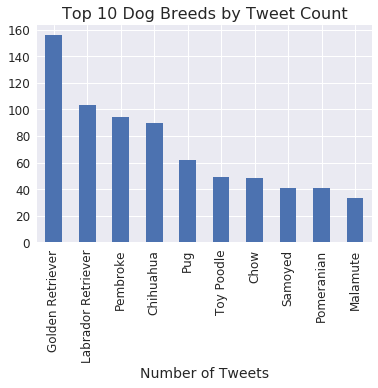

In [100]:
# Plot the result
top10_breeds_count.plot(kind='bar', y=top10_breeds_count.index, x=top10_breeds_count, color=[sns.color_palette()[0]])
plt.title('Top 10 Dog Breeds by Tweet Count', fontsize=16)
plt.xlabel('Number of Tweets', fontsize = 14)
plt.savefig('Top 10 Ratings Barplot.png', dpi=300, bbox_inches = "tight")
plt.show();

- The bar chart above shows that the most common dog that is tweeted about, with almost 160 tweets, is the Golden Retriever, as identified (predicted) by the neural network. 
- Labrador Retrievers, Pembrokes and Chihuahuas are fairly close together in 2nd, 3rd, and 4th place. 

### Question 2 : What dog breed got the highest retweet and favorite interactions?

We are using a filtered data, removing outliers. Then group by breed, aggregating the sum and calculate average retweet count & favorite count for each filtered breed.

In [101]:
# Set a boundary, where each breed should have atleast that number of tweets
boundary = df_breed.shape[0]/df_breed.breed.nunique()
boundary

14.672566371681416

In [102]:
# Filter the breeds based on boundary
filter_breed = df_breed.groupby('breed').count()
filter_breed = filter_breed[filter_breed.rating >= boundary]
filter_breed.tweet_id.unique()

array([ 15,  17,  20,  21,  31,  90,  48,  30,  22, 156, 103,  33,  19,
        24,  94,  41,  62,  18,  49,  16])

In [103]:
# Calculate the average retweet_count for breeds having tweet count more than or equal to boundary
retweet = round((df_breed.groupby('breed').sum() / filter_breed).retweet_count.dropna().sort_values(ascending=False) , 0)
retweet.head()

breed
French Bulldog    4303.0
Cocker Spaniel    3875.0
Eskimo Dog        3789.0
Samoyed           3722.0
Great Pyrenees    3523.0
Name: retweet_count, dtype: float64

In [104]:
# Calculate the average favorite_count for breeds having tweet count more than or equal to boundary
favorite = round((df_breed.groupby('breed').sum() / filter_breed).favorite_count.dropna().sort_values(ascending=False) , 0)
favorite.head()

breed
French Bulldog    16999.0
Samoyed           11419.0
Cocker Spaniel    11403.0
Eskimo Dog        10741.0
Cardigan          10611.0
Name: favorite_count, dtype: float64

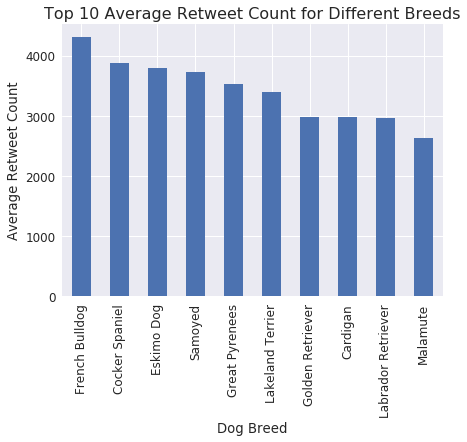

In [105]:
# Plot the top 10 response for retweet
plt.subplot(1,2,1)
retweet.nlargest(10).plot(kind='bar', color=[sns.color_palette()[0]], figsize=(15,5))
plt.title('Top 10 Average Retweet Count for Different Breeds', fontsize=16)
plt.xlabel('Dog Breed')
plt.savefig('Top 10 Average Retweet.png', dpi=300, bbox_inches = "tight")
plt.ylabel('Average Retweet Count');

- There is not much difference between the top 10 when looking at average retweet count. The noticable top breed being retweeted is the French Bulldog. 

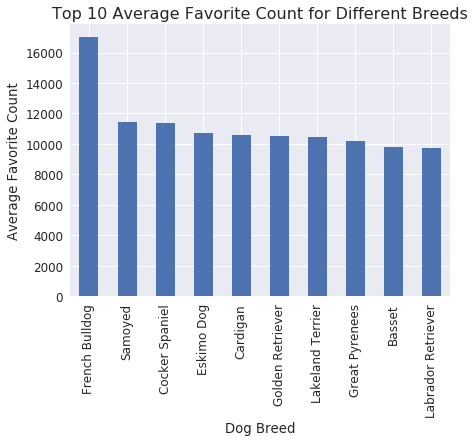

In [106]:
# Plot the top 10 response for favorite
plt.subplot(1,2,2)
favorite.nlargest(10).plot(kind='bar', color=[sns.color_palette()[0]], figsize=(15,5))
plt.title('Top 10 Average Favorite Count for Different Breeds', fontsize=16)
plt.xlabel('Dog Breed')
plt.ylabel('Average Favorite Count')
plt.savefig('Top 10 Average Favourite.png', dpi=300, bbox_inches = "tight");

- This visualization shows that French bulldogs have a large margin compared to the rest of the top 10 when it comes to the average tweet activity per post.

### Question 3: What is the correlation between ratings and the interactions by Twitter users?

In [107]:
df.sample(1)

,tweet_id,timestamp,rating,retweet_count,favorite_count,breed,confidence,name,stage,source,text,expanded_urls,jpg_url
1516,674739953134403584,2015-12-09 23:58:35,11.0,320,944,Dandie Dinmont,0.175915,None,None,Twitter for iPhone,"""🎶 DO YOU BELIEVE IN LIFE AFTER LOVE 🎶"" 11/10",https://twitter.com/dog_rates/status/674739953134403584/photo/1,https://pbs.twimg.com/media/CV0oaHFW4AA9Coi.jpg


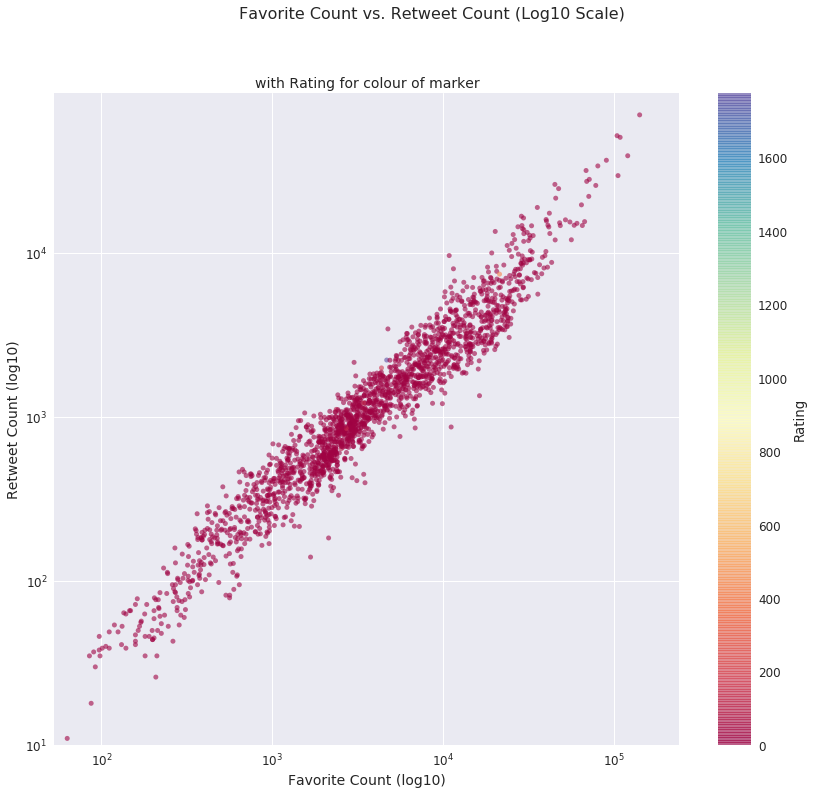

In [110]:
# https://stackoverflow.com/questions/25741214/how-to-use-colormaps-to-color-plots-of-pandas-dataframes
cmap = plt.get_cmap('Spectral') # Colour map (there are many others)
plt.figure(figsize = (14, 12))

plt.xscale('log')
plt.yscale('log')
plt.xlim(df['favorite_count'].min() - 10, df['favorite_count'].max() + 100000)
plt.ylim(10, df['retweet_count'].max() + 25000)
colours = df['rating']
markers = 25

plt.scatter(df['favorite_count'], df['retweet_count'], 
            c = colours, s = markers, cmap = cmap, edgecolor = 'None', alpha = 0.6)

# title and labels
plt.suptitle('Favorite Count vs. Retweet Count (Log10 Scale)', fontsize = 16)
plt.title('with Rating for colour of marker', fontsize = 14)
plt.xlabel('Favorite Count (log10)', fontsize = 14)
plt.ylabel('Retweet Count (log10)', fontsize = 14)

# colour bar
cbar = plt.colorbar()
cbar.set_label('Rating')

plt.savefig('Top 10 favorite vs retweet count with rating.png', dpi=300, bbox_inches = "tight")
plt.show();

- This plot is showing there is a positive correlation between retweet counts and favorite counts.
- The tightly packed points follow a distinct linear trend with a positive slope, so as favorite count increases so does the retweet count.
- Tweets with high favorite counts and high retweet counts also have higher ratings, as shown by the concentration of blue points.

### Question 4 : What is the weekly trend of interactions with WeRateDogs's posts?

In [111]:
# Starting date & last date in our dataset
df.timestamp.sort_values().min() , df.timestamp.sort_values().max()

(Timestamp('2015-11-15 22:32:08'), Timestamp('2017-08-01 16:23:56'))

In [112]:
# Group by day of the month
df_day = df.groupby(df.timestamp.dt.dayofweek).mean()[['rating','retweet_count','favorite_count']]
df_day

,rating,retweet_count,favorite_count
timestamp,,,
0,15.910769,2079.907692,7115.258462
1,10.980309,2181.742268,7760.536082
2,10.549828,2459.831615,8335.945017
3,11.248195,1952.595668,6847.602888
4,12.105632,2239.725632,7409.476534
5,10.552419,2422.641129,7844.447581
6,13.188976,2136.913386,7438.374016


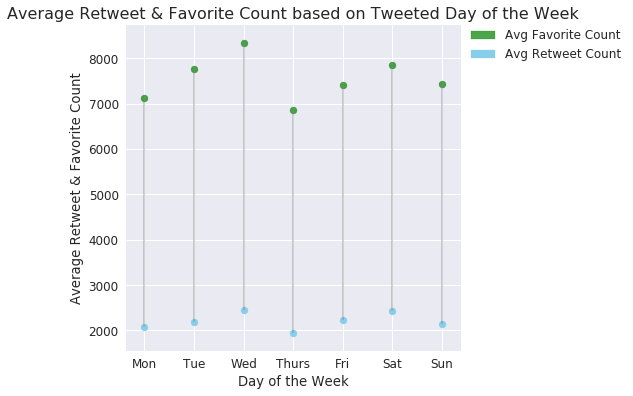

In [113]:
# Plot the response 
plt.figure(figsize=(6, 6))
my_range = range(7)

# The plot is made using the vline function
plt.vlines(x=my_range, ymin=df_day['retweet_count'], ymax=df_day['favorite_count'], color='grey', alpha=0.4)
plt.scatter(my_range, df_day['retweet_count'], color='skyblue', alpha=1)
plt.scatter(my_range, df_day['favorite_count'], color='green', alpha=0.7)

plt.title('Average Retweet & Favorite Count based on Tweeted Day of the Week', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Average Retweet & Favorite Count')

# add legend
top_bar = mpatches.Patch(color='green', label='Avg Favorite Count', alpha=0.7)
bottom_bar = mpatches.Patch(color='skyblue', label='Avg Retweet Count', alpha=1)
plt.legend(handles=[top_bar, bottom_bar], loc='upper left', bbox_to_anchor=(1, 1.02))

# x labels
plt.xticks(range(7), ['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'], rotation=0)
plt.savefig('Top 10 Average retweet & favorite count.png', dpi=300, bbox_inches = "tight");

- The retweet and Favorite Count on average increases gradually from Monday - Wednesday
- The count mostly drops during Mid-Week (Thursday) on average and then increases again before slight drop on Sunday.

### Question 5 : Which stage of dogs got the most interactions?

We are only considering the observations classified for stage. The data will be grouped by `stage` and then the sum will be aggregated.

In [114]:
# Consider only the observations classified for stage
df_stage = df.query('stage != "None"')

In [115]:
# Total number of tweets having stage value
df_stage.shape[0]

302

In [116]:
# Number of Unique stage
df_stage.stage.nunique()

6

In [117]:
# Check for outliers
df_stage.groupby('stage').count().tweet_id

stage
doggo             64
doggo,floofer      1
doggo,pupper       4
floofer            7
pupper           203
puppo             23
Name: tweet_id, dtype: int64

- There are 302 tweets for 6 unique stages in our dataset.
- There are three outliers, having very low tweet count.

In [118]:
# Set a boundary, where each stage should have atleast 10 tweets
boundary = 10

In [119]:
# Filter the breeds based on boundary
filter_stage = df_stage.groupby('stage').count()
filter_stage = filter_stage[filter_stage.tweet_id >= boundary]
filter_stage.tweet_id

stage
doggo      64
pupper    203
puppo      23
Name: tweet_id, dtype: int64

In [120]:
# Calculate the average rating, retweet count and favorite count for stages having tweet count more than or equal to boundary
# sort by rating
response  = (df_stage.groupby('stage').sum() / filter_stage)[['rating','retweet_count','favorite_count']].dropna()
response = pd.DataFrame(response.sort_values(by='rating'))
response

,rating,retweet_count,favorite_count
stage,,,
pupper,10.656502,1884.226601,6097.615764
doggo,11.734375,5705.109375,16737.328125
puppo,12.043478,5651.304348,19888.434783


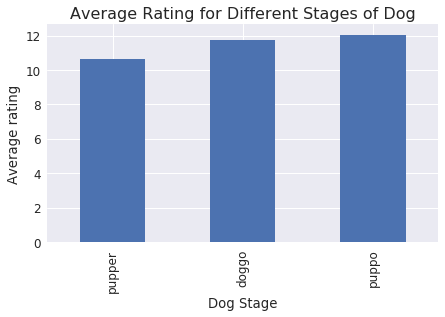

In [121]:
# Plot the response for average rating
response.rating.plot(kind='bar', color=[sns.color_palette()[0]], figsize=(7,4))
plt.title('Average Rating for Different Stages of Dog', fontsize=16)
plt.xlabel('Dog Stage')
plt.ylabel('Average rating')
plt.xticks(rotation=90);

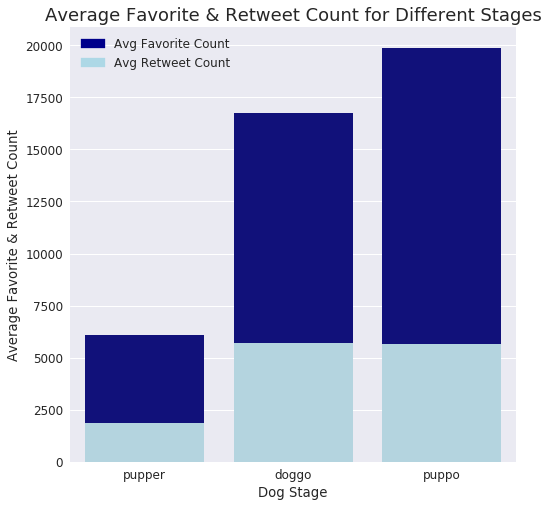

In [124]:
# set the figure size
plt.figure(figsize=(8, 8))

# bar chart 1 -> top bars (group of favorite_count)
bar1 = sns.barplot(x=response.index,  y="favorite_count", data=response, color='darkblue')

# bar chart 2 -> bottom bars (group of retweet_count)
bar2 = sns.barplot(x=response.index, y="retweet_count", data=response, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Avg Favorite Count')
bottom_bar = mpatches.Patch(color='lightblue', label='Avg Retweet Count')
plt.legend(handles=[top_bar, bottom_bar])

# add labels
plt.title('Average Favorite & Retweet Count for Different Stages', fontsize=18)
plt.xlabel('Dog Stage')
plt.ylabel('Average Favorite & Retweet Count')
plt.savefig('Average Favorite & Retweet Count for Different Stages', dpi=300, bbox_inches = "tight");

- Most rated & favorited stage of dog is puppo
- Most retweeted stage of dog is doggo